In [1]:
import HARK.ConsumptionSaving.ConsIndShockModel as Model        # The consumption-saving micro model
import HARK.ConsumptionSaving.ConsumerParameters as Params    # Parameters for the consumer type
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools
from time import time
mystr = lambda number : "{:.4f}".format(number)
do_simulation = True
import numpy as np
import matplotlib.pyplot as plt

#Notebooks to look for helpful code
# https://github.com/econ-ark/HARK/blob/master/HARK/SolvingMicroDSOPs/Code/StructEstimation.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsIndShockModel.py
# https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsumerParameters.py
# https://github.com/matthew-zahn/CGMPort/blob/develop/REMARK/CGM_REMARK.ipynb

In [2]:
#Set Parameters

Params.init_lifecycle["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_lifecycle["DiscFac"]= 0.96         # Default intertemporal discount factor (beta)
Params.init_lifecycle["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_lifecycle["aNrmInitMean"]= 0       # Mean of log initial assets 
Params.init_lifecycle["aNrmInitStd"]= 0.0      # Standard deviation of log initial assets
Params.init_lifecycle["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_lifecycle["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

Params.init_lifecycle['AgentCount'] = 1000                  #Change the number of agents simulated from default 10000 to 1000

#Unskilled Laborers: 3 percent growth from 25~40. flat for 40~65.

Params.init_lifecycle['PermGroFac'] = [1.03]*15 + [1]*25 + [0.7] + [1]*9     #Oringinally, [1.01,1.01,1.01,1.01,1.01,1.02,1.02,1.02,1.02,1.02]
Params.init_lifecycle['PermShkStd'] = [0.1]*50               #Originally, [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0]
Params.init_lifecycle['TranShkStd'] = [0.1]*50               #Originally, [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0]
Params.init_lifecycle['LivPrb']     = [1]*50                 #Originally, [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
Params.init_lifecycle['T_cycle']    = 50                     #Life starts at age 25 and ends at 75. Originally 10
Params.init_lifecycle['T_retire']   = 40                    #Agents retire at age 65. Originally 7
Params.init_lifecycle['T_age']      = 51                    #Make sure that old people die at terminal age and don't turn into newborns! Originally 11

In [3]:
Lifecycle_Unskilled = Model.IndShockConsumerType(**Params.init_lifecycle)
Lifecycle_Unskilled.cycles = 1 #1 for finite horizon and 0 for infinite horizon

start_time = time()
Lifecycle_Unskilled.solve()
end_time = time()
print('Solving a lifecycle consumer took' +mystr(end_time-start_time) +' seconds.')
Lifecycle_Unskilled.unpackcFunc()
Lifecycle_Unskilled.timeFwd() #make sure that time is moving forward

Solving a lifecycle consumer took0.0290 seconds.


Consumption functions while working:


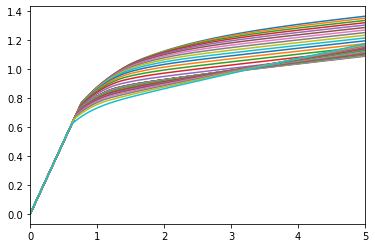

Consumption functions while retired:


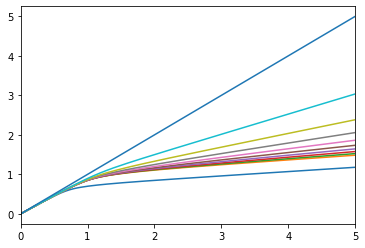

In [4]:
print('Consumption functions while working:')


mMin = min([Lifecycle_Unskilled.solution[t].mNrmMin for t in range(Lifecycle_Unskilled.T_cycle)])
#Finds the minimum of Lifecycle_Unskilled.solution[t].mNrmMin for t = 0~49
#mNrmMin: The minimum allowable market resources for this period; the consumption function (etc) are undefined for m < mNrmMin.


plotFuncs(Lifecycle_Unskilled.cFunc[:Lifecycle_Unskilled.T_retire],mMin,5)
#This plots the consumption function for life periods 0~40. Plots it with respect to wealth from 0 to 5.
#The highest curve is for period 0.

print('Consumption functions while retired:')
plotFuncs(Lifecycle_Unskilled.cFunc[Lifecycle_Unskilled.T_retire:],0,5)
#Highest graph represents consumption in last period. MPC is 1 since the consumer consumes everything in the second to last period.

Lifecycle_Unskilled.timeRev()
#Set time to reverse so that simulations solve using backward induction

In [14]:
if do_simulation:
    Lifecycle_Unskilled.T_sim = 50 #simulate Lifecycle_Unskilled.T_sim periods for 10000(default) agents
    Lifecycle_Unskilled.track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','t_age'] #track these variables
    Lifecycle_Unskilled.initializeSim()
    Lifecycle_Unskilled.simulate()

In [15]:
Lifecycle_Unskilled_avinc = Lifecycle_Unskilled.pLvlNow_hist@np.ones(1000)/1000
Lifecycle_Unskilled_avcons = Lifecycle_Unskilled.cNrmNow_hist@np.ones(1000)/1000
Lifecycle_Unskilled_avm = Lifecycle_Unskilled.mNrmNow_hist@np.ones(1000)/1000
Lifecycle_Unskilled_ava = Lifecycle_Unskilled.aNrmNow_hist@np.ones(1000)/1000

#Lifecycle_Unskilled.pLvlNow_hist is a (Lifecycle_Unskilled.T_sim * Lifecycle_Unskilled.AgentCount) Matrix or array.
#Lifecycle_Unskilled.pLvlNow_hist[t] shows pLvlNow of 1000 different consumers in period t
#len(Lifecycle_Unskilled.pLvlNow_hist[0]) shows the number of elements in Lifecycle_Unskilled.pLvlvNow_hist[0].
#sum(Lifecycle_Unskilled.pLvlNow_hist[0]) is the sum of pLvlNow over all agents in period 0
#For each period get the average of pLvlNow income over all agents
#This is defined as Lifecycle_Unskilled_avinc. It is a (Lifecyle_Unskilled.T_sim * 1) array

#Lifecycle_Unskilled_avcons is the average consumption of agents for each period

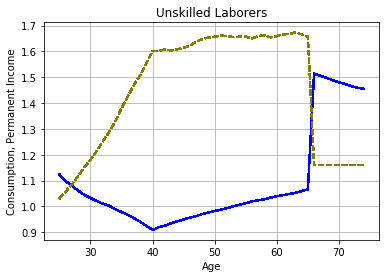

In [24]:
plt.figure()
plt.plot(Lifecycle_Unskilled.t_age_hist+24, Lifecycle_Unskilled_avcons, 'b') #add 24 to make consumption start from 25 and end at 75
plt.plot(Lifecycle_Unskilled.t_age_hist+24, Lifecycle_Unskilled_avinc, 'olive', linestyle = 'dashed')
#plt.plot(Lifecycle_Unskilled.t_age_hist+24, Lifecycle_Unskilled_avm, 'r', linestyle = 'dashed')
#plt.plot(Lifecycle_Unskilled.t_age_hist+24, Lifecycle_Unskilled_ava, 'cyan', linestyle = 'dashed')
plt.xlabel('Age')
plt.ylabel('Consumption, Permanent Income')
plt.title('Unskilled Laborers')
plt.grid()

#Permanent income looks correct. However consumption is wrong. Need to correct for consumption. First, there shouldn't be any kinks. Second, Consumption should increase during preretirement and decrease after.